Copyright (c) 2023, University of Cambridge, all rights reserved. Written by Andrew Wheeler, University of Cambridge



# Desktop DNS Notebook 3: Mesh sensitivity and quality checks

---
### User agreement and correct use of these tools
This notebook and associated Python code are provided for non-commericial/academic use only. For those interested in commercial application of these tools please contact Andrew Wheeler (e-mail: aw329@cam.ac.uk). Please read the license agreement (LICENSE.txt).


If you use these tools for a publication please include the citation:

*Wheeler A.P.S. (2023) 'Desktop-DNS: An open toolkit for turbomachinery aerodynamics', ASME Turbo Expo 2023, ASME Paper no. GT2023-1023647*


---

## 3.0 Introduction

In this notebook you will investigate the effect of mesh resolution on the flow. This will involve successive mesh refinement using the meshing tool. In order to avoid excessive transients, the flow is interpolated from previous simulations onto the finer meshes.  You will then use analysis of the entropy transport equation to assess the resolved dissipation. The flow statistics can also be used to estimate the Kolmogorov length-scale, which can be used to assess the mesh resolution. The notebook sections are:

* Flow interpolation onto finer meshes
* Comparison of cases with different mesh sizes
* Entropy budget analysis
* Checking the cell size against the Kolmogorov length scale


The *3DNS-gpu* user guide can be found in the repository docs here: <a href="docs/userguide_3dns_gpu_May_2023.pdf"> <i>3DNS-gpu</i> userguide</a> and gives more detail on the code including the format for the input and output files and running of the code.

A description of the Python routines used in these notebooks is given in the 'tools.ipynb' notebook. This lists the inputs and outputs for each of the main functions used.

---

In [351]:
# this cell ensures that python modules are reloaded at runtime

%reload_ext autoreload
%autoreload 2


## 3.1 Interpolating onto a finer mesh

### Creating a finer mesh
In Notebook 2 you established a coarse 3D case. We now want to interpolate this flow onto a finer mesh. We can create a finer mesh using the meshing tool described in Notebook 1.

The refinement factor below can be used to increase the mesh resolution. The refinement factor 'refine_fac' scales the grid points in each i,j direction. 


In Notebook 1 we set 'refine_fac=2'. In the cell below the 'refine_fac' is set to 3, and therefore the i-j points will be increased by a factor of $(3/2)^2 = 2.25$ compared to the baseline mesh.


In [17]:


# create refined mesh

# inilitialize dictionaries
mesh   = {}

# case name and profile coordinates
mesh['case'] = 'notebook3/mesh1'
mesh['profile'] = 'geom/profile.txt'

# initial mesh inputs
mesh['npp'] = 2*[None]
mesh['ywall'] = 2*[None]
mesh['msmooths'] = 2*[None]

mesh['npp'][0] = 4
mesh['Lup'] = 1.0
mesh['Ldn'] = 1.0
mesh['Lo'] = 0.2
mesh['ywall'][0] = 0.04/150
mesh['msmooths'][0] = 500
mesh['cor_fac'] = 0.75 # factor shrinking multi-block corner cells - lower values give more shrinkage.

# final mesh inputs
mesh['npp'][1] = 28
mesh['refine_fac'] = 3 # use refinement factor to increase mesh points in i-j directions 
mesh['ywall'][1] =  0.02/150 
mesh['msmooths'][1] = 200

# scale factor if used (set to 1.0 if not)
mesh['scale_factor'] = 1.0

# flip y coordinates if -1 (1 for no flip)
mesh['flip'] = 1




The meshing tool inputs are now set. Running the next cell creates the mesh - the bigger the mesh, the longer it takes for the mesher to run. Wait till the cell is complete before continuing.

In [18]:
from meshing.blade_mesher import *
import timeit

start = timeit.default_timer()

# create mesh 
case = blade_mesher(mesh)

stop = timeit.default_timer()

print('Time: ', stop - start)  




Time:  167.75252096704207


Plot the mesh and check you are happy with the mesh quality.

In [357]:
import matplotlib.pyplot as plt

# pop-out figures
%matplotlib qt

#%matplotlib inline


# unpack case for plotting
blk = case['blk']

# plot profile, topology and mesh
plt.figure(1)
plt.axis('equal')

for ib in range(len(blk)):
    xnew=blk[ib]['x']
    ynew=blk[ib]['y']
    plt.plot(xnew,ynew,'k')
    plt.plot(np.transpose(xnew),np.transpose(ynew),'k')

plt.show()


### Interpolation

Now we can interpolate the solution from the coarse mesh onto the new fine mesh. Make sure the casenames are set correctly so that the old and new case files are read and written to the correct directories.

At this point we can now adjust the number of spanwise points as well. In the cell below nk is set to 51. 

In [20]:
from postpro.interp_flo import *
from meshing.read_case import *
from meshing.write_flo import *
from meshing.write_case import *


# interpolate old flow files onto new grid
casename_old = 'notebook2'
casename_new = 'notebook3/mesh1'


# read casefiles from old directory
case_old = read_case(casename_old)

# pack-up new case
case['casename'] = casename_new
case['bcs'] = case_old['bcs']
case['gas'] = case_old['gas']
case['solver'] = case_old['solver']

# set number of spanwise points
case['solver']['nk'] = 51 # spanwise points for 3D calculation 

# adjust number of iterations
case['solver']['niter'] = 50000

# set adjust spanwise extent if needed
case['solver']['span'] = 0.1 #  
case['solver']['sigma'] = 0.01 # set filter coefficient (finer meshes permit lower values)
 
# write new casefiles
write_case(case)

# interpolate onto new mesh
prop = interp_flo(casename_old,casename_new)

# write the new flo files
write_flo(prop,casename_new)





gpu input file found
2
Writing inputs for 3dns_gpu
Total ij points
558208
Total GPUs
1
gpu input file found
2
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
gpu input file found
2



Before running it is sensible to check the flow files - use the read_flo and plot_flo routines to read-in and plot the interpolated flow to make sure the interpolation has been successful.

Once you are happy with the new flow set up you are ready to run the simulation in the usual way. The case files above are copied-over from Notebook 2 and so the input file is set-up to run the case on 4 GPUs (as described in Notebook 2).



The table below is an estimate of the running costs for a 28 million point mesh on AWS.


| VM instance | GPU  | approx. \$/hr*| time per step(s)|\$ for 600k steps* | 
|-------------|------|---------------|--------|----|
| p3.8xlarge  |4 x V100 | 3.6 (12)   | 0.117  | 70.2 (234) | 

*Estimated spot price (values in brackets are the estimated on-demand price) for a 28M point grid




---

## 3.2 Compare cases
Now try creating and running another mesh. Repeat section 3.1 with a different refinement factor. 
You can also adjust the near wall cell size; 'ywall' sets the wall normal cell height for the cell adjacent to the viscous walls. It is also possible to increase the cfl number - values of upto 1.5 are possible and will reduce compute costs. The filter coefficient (sigma) can be adjusted to increase or reduce the level of explicit filtering.

Make sure to set a new casename (e.g. 'notebook3/mesh2') - otherwise you risk overwriting your current case! 
Also make sure to set the old casename to read in the previous best simulation (e.g. 'notebook3/mesh1'). Always keep the files up-to-date in your notebook directory - copying the casefiles from where you are running on your AWS instance. The interpolation routines relies on having up-to-date flow files in the notebook directory.

When running each new case, assess the statistical convergence (as described in Notebook 2) and carefully select the integration time in order to avoid an initial transients and to make sure the integration time is sufficiently long to ensure statistical convergence.

Below is a table showing 3 cases run with different choices of mesh resolution. Also shown are the wake profiles these 3 cases, showing that above a around 70 million points, there is very little change in the wake profile. 

The Appendix at the end of this notebook shows an example of how to compare different cases.



| Mesh points | refine_fac | ywall (m) | cfl | sigma | nk | integration time (s) |
|-|-|-|-|-|-|-|   
|28468608 |3| 1.3e-4 | 1.0 | 0.01 | 51 | 0.1728 |
|68856368 |4| 1.3e-4 | 1.0 | 0.01 | 71 | 0.1859 |
|151350416|6| 2e-4   | 1.5 | 0.01 | 71 | 0.1152 |


Wake profile of total pressure loss coefficient ($Y_p$) at $x/c_{ax}=1.25$

![WAKES](images/wakes.png)


We now have a good idea of how many mesh points we require to achieve mesh independence of loss. You may wish to use the post-processing routines to assess mesh sensitivity to other performance criteria - such as loading and deviation (see Notebook 2).


---

## 3.3 Entropy budget analysis

Now we make use of the entropy transport equation to assess how well resolved the cases are. The entropy transport equation is:

$\begin{equation}
\rho\frac{Ds_{irr}}{Dt} = \rho\frac{Ds}{Dt} + \nabla \cdot \left( \frac{q}{T} \right) =  \frac{\phi}{T} + \dot{S}_N  +\theta .
\label{eq:sgen}
\end{equation}$

On the left-hand-side is the irreversible entropy generation rate, which is the sum of the entropy generation and contribution due to heat transfer rate. This represents the true entropy change in the flow and directly governs the loss. On the right is the contribution due to resolved dissipation $\phi/T$ and $\dot{S}_N$ which is the entropy generation rate per unit volume due to numerical dissipation within the simulation. The contribution due to irreversible heat transfer $\theta$ across finite temperature differences can be safely ignored in low speed adiabatic cases such as this ($\theta\approx0$).

Resolving the full dissipation spectrum requires capturing the very smallest-scales in the flow.  Under-resolved calculations underestimate the dissipation $\phi$ because this is computed using the resolved gradients in the flow. The irreversible entropy generation rate on the other hand contains the effects of both the resolved dissipation and numerical dissipation required to stabilize the numerical scheme; in *3DNS-gpu* this is applied using the $8^{th}$ order explicit filter. 

When integrated over a volume, the irreversible entropy generation rate will be larger and less resolution dependent than determining dissipation from the resolved flow. The entropy "budget" is therefore very useful because it allows us to quantify the unresolved dissipation. Therefore in *3DNS-gpu* the quantities $\rho u s, \rho v s, q_x/T, q_y/T, \phi/T$ are included in the time-average quantities.

We can determine the resolved loss generation (due to dissipation) and entropy flux by integration within a control volume $\Omega$:

$\begin{equation}
 \Sigma_{res} = \int_{\Omega} \frac{\phi}{T} d\Omega
\end{equation}$

$\begin{equation}
 \Sigma_{flux} = \int_{\Omega} \frac{Ds_{irr}}{Dt} d\Omega
\end{equation}$



This figure shows the cumulative rise in entropy through the domain, comparing the resolved and actual entropy generation rate for a 151 million point mesh. 
![SGEN](images/entropybudget.png)

The next two cells below can be used to generate the same plot for your cases.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from postpro.read_2d_mean import *
from postpro.sumvolx import *

# pop-out figures
#%matplotlib qt
%matplotlib inline

# set the casename 
casename = 'notebook3/mesh3'

prop,geom,_=read_2d_mean(casename,[6]);
xpos = np.linspace(-0.5,1.5,100);

irrev_entropy_flux  = sumvolx(prop,geom,'Dsi',xpos);
resolved_diss = sumvolx(prop,geom,'dissT',xpos);


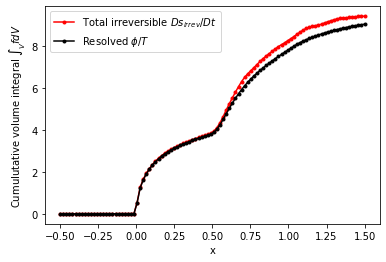

In [3]:
plt.figure(1)
plt.plot(xpos,irrev_entropy_flux,'-r.')
plt.plot(xpos,resolved_diss,'-k.')
plt.xlabel('x')
plt.ylabel('Cumulutative volume integral $ \int_V f dV $')
plt.legend(['Total irreversible $Ds_{irrev}/Dt$',
            'Resolved $\phi/T$'])
plt.show()

The next cell shows a bar chart of the resolved and total irreversible entropy rise at $x/c_{ax}=1.1$.

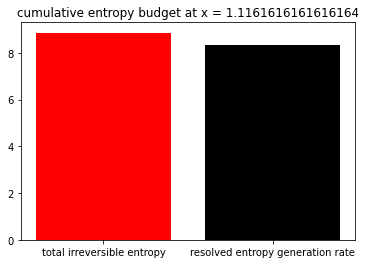

ratio of resolved to total irreversible entropy generation rate = 93.87083636095973%


In [4]:
plt.figure(2)
iplot = 80
plt.bar([0,1],[irrev_entropy_flux[iplot,0],resolved_diss[iplot,0]], 
        tick_label=['total irreversible entropy','resolved entropy generation rate'],color=['r','k'])
plt.title('cumulative entropy budget at x = '+str(xpos[iplot]))
plt.show()

print('ratio of resolved to total irreversible entropy generation rate = ' 
      + str(100*resolved_diss[iplot,0]/irrev_entropy_flux[iplot,0]) + '%')



The table below shows the resolved and total irreversible entropy generation for the 3 meshes described above. Increasing mesh resolution increases the amount of resolved dissipation from around 87 percent with the 28 million point mesh to around 94 percent for the 151 million point mesh.

You can see that the total irreversible entropy generation is relatively insensitive, compared to the resolved dissipation. The variations in total irreversible entropy are around 2 percent, while the resolved dissipation varies by around 9 percent. This is good news because it tells us that we can get high quality predictions by capturing around 90 percent of the dissipation. Increasing the number of mesh points will not improve the performance prediction and will cost a great deal more. The entropy budget analysis shows us that capturing the remaining 10 percent is not going to give us an improvement in performance prediction.

Furthermore, it is very encouraging that we achieve a very good level of accuracy even with the 28 million point mesh. This is further justification for running cases on a relatively modest mesh size first, before scaling the mesh size up. We can learn a lot about the flow even on a modest size mesh.

| Mesh points | total irreversible entropy flux (W/K) | resolved entropy generation (W/K) | ratio (as $\%$) |
|-|-|-|-|   
|28468608 |8.8218|7.6412|86.6|
|68856368 |8.9819|8.1646|90.9|
|151350416|8.8609|8.3178|93.9|



We can also plot the entropy generation rate profile within the boundary layer. The next cell plots the terms in the entropy budget at a point in the suction-side boundary layer.


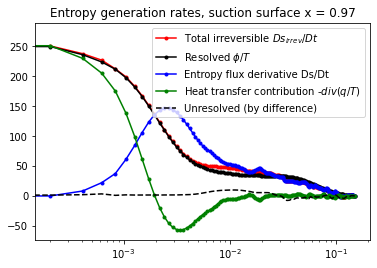

In [6]:
plt.figure(1)
ib = 5 # suction-surface
iplot = -10 # i-index for plotting

x = geom[ib-1]['x'][iplot,:]
y = geom[ib-1]['y'][iplot,:]

# distance to wall
yn = np.sqrt((x-x[-1])**2.0 + (y-y[-1])**2.0)

plt.semilogx(yn,prop[ib-1]['Dsi'][iplot,:],'-r.')
plt.semilogx(yn,prop[ib-1]['dissT'][iplot,:],'-k.')
plt.semilogx(yn,prop[ib-1]['Ds'][iplot,:],'-b.')
plt.semilogx(yn,prop[ib-1]['Dsr'][iplot,:],'-g.')
plt.semilogx(yn,prop[ib-1]['Dsi'][iplot,:]-prop[ib-1]['dissT'][iplot,:],'--k')

plt.title('Entropy generation rates, suction surface x = '+str(np.floor(x[-1]*100.0)/100))
plt.legend(['Total irreversible $Ds_{irrev}/Dt$',
            'Resolved $\phi/T$',
            'Entropy flux derivative Ds/Dt',
            'Heat transfer contribution -$div(q/T)$',
            'Unresolved (by difference)'])

plt.show()


It is interesting to see that the entropy flux term $\rho Ds/Dt$ peaks at around $y^+\simeq10$ and tends to zero at the wall; this is because the flow speed at the wall is zero and therefore there is no entropy flux. While the entropy flux is zero, the irreversible entropy generation rate is not and this is because the heat-transfer term $\nabla \cdot (q/T)$ is equal and opposite to the dissipation term $\phi/T$. At first it seems surprising that for an adiabatic case such as this, that the heat transfer term should be of similar magnitude to the dissipation; although the first derivative of temperature at the wall is zero (set by the adiabatic condition) the second derivative must balance the dissipation for a no-slip wall. 



---

## 3.4 Check the cell size against Kolmogorov length scale

Now that we are confident that we are capturing the vast majority of the resolved dissipation, we can assess our mesh resolution once again. The dissipation can be used to estimate the Kolmogorov length-scale and using this we can determine mesh resolution. Whereas the near-wall cell aspect ratios should be in the region of $10-15$, the free-stream cell aspect ratios ought to be around 1. It therefore follows that the free-stream cell sizes will be around 10 in $+$ units. This is quite different to most RANS calculations where coarsening the mesh in the freestream is a sensible approach to reducing compute costs. In DNS, this will lead to poor resolution of turbulence within the passage and lead to higher frequency (smaller wavelength) turbulence being dissipated prematurely or incurring dispersion errors. In regions where the turbulence is likely to be more isotropic (such as in the far wake of a blade), a rule of thumb is to set cell lengths to be within 10 Kolmogorov length-scales. 

We can compute turbulent dissipation from the time-average dissipation:
$\begin{equation}
\eta =\left({\frac {\nu ^{3}}{\varepsilon }}\right)^{1/4}
\end{equation}$

where $\varepsilon = \overline{\phi} - \Phi$, is the turbulent dissipation and $\Phi$ is the dissipation due to the time-mean strain computed from the time-average flow field. 

As discussed above, poorly-resolved simulations will tend to underestimate the predicted dissipation and will thus overestimate $\eta$, giving an unreliably optimistic estimate of cell sizes. Therefore the estimation of the Kolmogorov length-scale should be treated with some caution.

The cell below plots the ratio of the cell length $\Delta_{cell}$ to the Kolmogorov length scale $\eta$ using the method described above. The cell length $\Delta_{cell}$ is taken as the square root of the cell in the blade-to-blade plane. For the typical mesh sizes shown here, you will find  cell sizes $\Delta_{cell}<5\eta$, further confirming the cases are well resolved.


<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

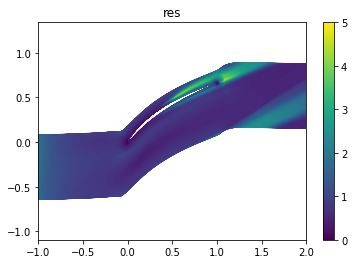

In [9]:
from postpro.plot_flo import *

# set the casename 
casename = 'notebook3/mesh1'

# read the mean flow
prop,geom,_=read_2d_mean(casename,[6]);

# plot the ratio of L_kol to cell size
plot_flo(prop,geom,'res',[0,5])



You are now ready to move to Notebook 4 where we make use of the DNS data to perform RANS simulations.


---

## Appendix

The cell below is an example of how you might compare several cases.

In [392]:
import numpy as np
import matplotlib.pyplot as plt
import os

from postpro.read_2d_mean import *
from postpro.yp import *

# pop-out figures
%matplotlib qt

path = os.getcwd()


casenames = ['notebook3/mesh1','notebook3/mesh2','notebook3/mesh3']
colours = ['k','b','r']


inlet = {}
exit = {}

inlet['blocks'] = [1,2]
exit['blocks'] = [8,9]

inlet['x']= -0.5 # avoid buffer regions near inlet bc
exit['x'] = 1.25 # avoid buffer regions near exit bc

plt.figure(1)
Yp = np.zeros(len(casenames))
points = np.zeros(len(casenames))
for n,casename in enumerate(casenames):
    c = colours[n]
    
    # read block dimensions  
    nijk = np.genfromtxt(os.path.join(path,casename,'blockdims.txt'),dtype=int)
    npts = np.sum(nijk[:,0]*nijk[:,1]*nijk[:,2])
    
    # make sure nfiles is set to avoid any 
    # initial transients and is sufficient for statistical convergence
    prop,geom,time=read_2d_mean(casename,[6]);
    perf = yp(prop,geom,inlet,exit);
    wake = perf['wake']
    y = wake['y']
    y_p = wake['yp']
    # periodic repeat
    y = np.append(y,y+1)
    y_p = np.append(y_p,y_p)       
    plt.plot(y,y_p,c)
    Yp[n] = perf['yp']
    points[n] = npts/1e6
    print(casename,npts,time,Yp[n])
    
plt.legend(points.astype(int))
    
plt.ylabel('Yp')
plt.xlabel('fraction of pitch')
plt.show()

plt.figure(2)
plt.plot(points,Yp)
plt.ylabel('Yp')
plt.xlabel('million points')
plt.show()




notebook3/mesh1 28468608 0.1728033 0.022763319495959448
notebook3/mesh2 68856368 0.18594998 0.024103485839857483
notebook3/mesh3 151350416 0.13818106 0.02280069764988225
